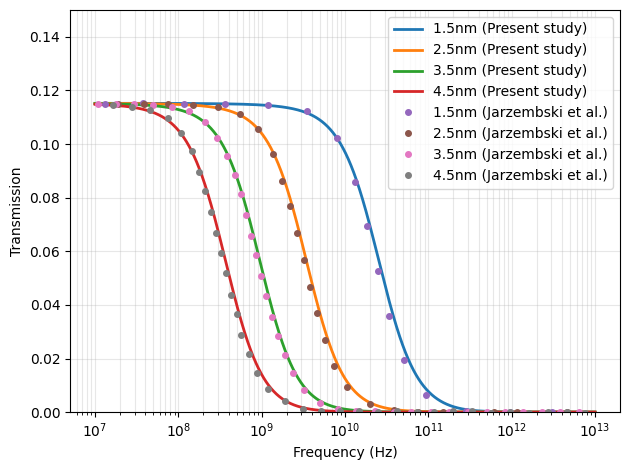

In [7]:
import numpy as np
import matplotlib.pyplot as plt

#Verification result of
# Role of acoustic phonon transport in near- to asperity-contact heat transfer

# Parameters
N = 10
k_pt = 6.31
k_si = 6.16
m_pt = 3.239e-25
m_si = 4.664e-26
r_pt = 1.77e-10
r_si = 1.11e-10

Area_SiPt = np.pi * ((r_pt + r_si) / 2.0) ** 2
Area_tip = (240e-9 / np.sqrt(2.0)) ** 2
Q_s = (8e-4) * Area_tip

eps0 = 8.854e-12
V_bias = 0.8
sigma = 1.84e-10
Eps = 4.80e-20

# Vacuum gaps (m)
del_list = np.array([1.5e-9, 2.5e-9, 3.5e-9, 4.5e-9])

# Frequency grid
OD = 40000
nu = np.logspace(7, 13, OD)          # Hz
omega = 2.0 * np.pi * nu             # rad/s

Transmission = np.zeros((len(del_list), OD), dtype=float)



# Surface Green's function by decimation
def surface_g_decimation(omega_i, k, m, tol=1e-30, itmax=10000):
    delta = 0.1 * omega_i * omega_i
    H_OS = omega_i**2 + 1j * delta - (2.0 * k / m)
    H_0b = omega_i**2 + 1j * delta - (2.0 * k / m)
    tau_0 = k / m

    for _ in range(itmax):
        if abs(tau_0) < tol:
            break
        tau_1 = -(tau_0**2) / H_0b
        H_1b = H_0b + 2.0 * tau_1
        H_1S = H_OS + tau_1

        tau_0 = tau_1
        H_0b = H_1b
        H_OS = H_1S

    return 1.0 / H_OS

# Main loop over vacuum gaps
p=4
for j, d in enumerate(del_list):

    # k_coulomb
    k_coulomb = abs((Q_s / (4.0 * np.pi * eps0)) * (
        (2.0 * Q_s) / (d**3) + (3.0 * eps0 * V_bias * Area_tip) / (d**4)
    ) * (Area_SiPt / Area_tip))

    # k_LJ
    k_LJ = abs(24.0 * Eps * ((26.0 * (sigma**12) / (d**14)) - (7.0 * (sigma**6) / (d**8))))

    k_vacuum = k_coulomb + k_LJ

    # Build H matrix
    H = np.diag((2.0 * k_pt / m_pt) * np.ones(N))
    H += np.diag((-k_pt / m_pt) * np.ones(N - 1), 1)
    H += np.diag((-k_pt / m_pt) * np.ones(N - 1), -1)

    H[p, p] = - (-(k_pt / m_pt) - (k_vacuum / np.sqrt(m_pt * m_si)))
    H[p + 1, p + 1] = - (-(k_si / m_si) - (k_vacuum / np.sqrt(m_pt * m_si)))
    H[p, p + 1] = -k_vacuum / m_si
    H[p + 1, p] = -k_vacuum / m_pt

    for r in range(7, 11):
        rr = r - 1
        H[rr, rr - 1] = -k_si / m_si
        H[rr - 1, rr] = -k_si / m_si
        H[rr, rr] = 2.0 * (k_si / m_si)

    D_C = H

    Sigma_pt = np.zeros((N, N), dtype=complex)
    Sigma_si = np.zeros((N, N), dtype=complex)

    for I in range(OD):
        w = omega[I]

        g_pt = surface_g_decimation(w, k_pt, m_pt)
        g_si = surface_g_decimation(w, k_si, m_si)

        Sigma_pt.fill(0.0)
        Sigma_si.fill(0.0)
        Sigma_pt[0, 0] = (-k_pt / m_pt) * g_pt * (-k_pt / m_pt)
        Sigma_si[N - 1, N - 1] = (-k_si / m_si) * g_si * (-k_si / m_si)

        G1 = np.linalg.inv((w * w) * np.eye(N) - D_C - Sigma_pt - Sigma_si)
        G2 = G1.conj().T

        Gamma1 = np.imag(Sigma_pt)
        Gamma2 = np.imag(Sigma_si)

        Trans = 4.0 * np.real(np.trace((G1 @ Gamma1) @ (G2 @ Gamma2)))
        Transmission[j, I] = Trans


# Plot: present model curves
for j, d in enumerate(del_list):
    plt.semilogx(nu, Transmission[j, :], linewidth=2,
                 label=f"{d*1e9:.1f}nm (Present study)")

# Overlay verification points (Jarzembski et al.)
# Provide files: 1.5nm.txt, 2.5nm.txt, 3.5nm.txt, 4.5nm.txt
# Each file: two columns [frequency_Hz, transmission]
verification_files = {
    "1.5nm.txt": ("1.5nm (Jarzembski et al.)", "o"),
    "2.5nm.txt": ("2.5nm (Jarzembski et al.)", "o"),
    "3.5nm.txt": ("3.5nm (Jarzembski et al.)", "o"),
    "4.5nm.txt": ("4.5nm (Jarzembski et al.)", "o"),
}

for fname, (lab, marker) in verification_files.items():
    try:
        data = np.loadtxt(fname, delimiter=",")
        x = data[:, 0]
        y = data[:, 1]
        plt.semilogx(x, y, marker, markersize=4, linestyle="None", label=lab)
    except OSError:
        print(f"Could not find file: {fname} (put it in the same folder as this script/notebook).")

plt.xlabel("Frequency (Hz)")
plt.ylabel("Transmission")
plt.ylim(0, 0.15)
plt.xticks([1e7, 1e8, 1e9, 1e10, 1e11, 1e12, 1e13])
plt.grid(True, which="both", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
